# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [205]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
import re
import ast
from pprint import pprint
from functions_variables import encode_tags
from functions_variables import encode_primary_photo
from functions_variables import encode_source
from functions_variables import categorize_cost_of_living
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Importing

In [206]:
# Directory containing JSON files
directory = "data" #Moved folder inside notebook folder

# Initialize an empty list to store data
data_list = []

# Loop through each JSON file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        file_path = os.path.join(directory, filename)
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                data = json.load(file)  # Load JSON data

            # Check if expected keys exist before accessing them
            if isinstance(data, dict) and "data" in data and isinstance(data["data"], dict) and "results" in data["data"]:
                for record in data["data"]["results"]:
                    if isinstance(record, dict):  # Ensure record is a dictionary before processing
                        flat_record = record.copy()

                        # Extract state and city from location
                        flat_record["state"] = None
                        flat_record["city"] = None

                        if "location" in record and isinstance(record["location"], dict):
                            address = record["location"].get("address", {})
                            flat_record["state"] = address.get("state", None)
                            flat_record["city"] = address.get("city", None)
                            flat_record["postal_code"] = address.get("postal_code", None)

                        # Flatten description
                        if "description" in record and isinstance(record["description"], dict):
                            flat_record.update(record["description"])
                            del flat_record["description"]

                        # Flatten products (dictionary)
                        if "products" in record and isinstance(record["products"], dict):
                            flat_record.update(pd.json_normalize(record["products"]).to_dict(orient="records")[0])
                            del flat_record["products"]

                        # Append flattened record to list
                        data_list.append(flat_record)

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in file {filename}: {e}")

# Convert list of dictionaries into a DataFrame
df_combined = pd.DataFrame(data_list)

# Display or save the combined DataFrame
print(df_combined[["state", "city","postal_code"]].head())  # View extracted state and city columns
df_combined.to_csv("combined_data.csv", index=False)  # Save as CSV

    state    city postal_code
0  Alaska  Juneau       99801
1  Alaska  Juneau       99801
2  Alaska  Juneau       99801
3  Alaska  Juneau       99801
4  Alaska  Juneau       99801


## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [207]:
df_combined.info()
df_combined.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   primary_photo         7403 non-null   object 
 1   last_update_date      8125 non-null   object 
 2   source                7752 non-null   object 
 3   tags                  7638 non-null   object 
 4   permalink             8159 non-null   object 
 5   status                8159 non-null   object 
 6   list_date             7752 non-null   object 
 7   open_houses           0 non-null      object 
 8   branding              8159 non-null   object 
 9   list_price            7721 non-null   float64
 10  lead_attributes       8159 non-null   object 
 11  property_id           8159 non-null   object 
 12  photos                7403 non-null   object 
 13  flags                 8159 non-null   object 
 14  community             5 non-null      object 
 15  virtual_tours        

,list_price,price_reduced_amount,year_built,baths_3qtr,sold_price,baths_full,baths_half,lot_sqft,sqft,baths,garage,stories,beds,products
count,7.721000e+03,2.484000e+03,7316.000000,566.000000,6.716000e+03,7311.000000,2281.000000,6.991000e+03,7323.000000,7980.000000,4448.000000,6260.000000,7504.000000,0.0
mean,4.341582e+05,2.442704e+04,1968.916074,1.247350,4.126050e+05,1.887430,1.105655,2.510949e+05,1933.848559,2.131203,1.926709,1.567732,3.208289,NaN
std,5.514925e+05,7.162396e+04,35.096914,0.463482,6.994308e+05,0.862214,0.413340,5.823820e+06,1339.039206,1.175940,0.878766,0.730969,1.282732,NaN
min,1.000000e+00,1.000000e+02,1828.000000,1.000000,3.080000e+02,1.000000,1.000000,0.000000e+00,120.000000,0.000000,1.000000,1.000000,0.000000,NaN
25%,2.090000e+05,6.000000e+03,1950.000000,1.000000,1.910000e+05,1.000000,1.000000,4.953000e+03,1258.000000,1.000000,1.000000,1.000000,3.000000,NaN
50%,3.250000e+05,1.010000e+04,1975.000000,1.000000,3.140000e+05,2.000000,1.000000,7.841000e+03,1635.000000,2.000000,2.000000,1.000000,3.000000,NaN
75%,4.999000e+05,2.000000e+04,1997.000000,1.000000,4.700000e+05,2.000000,1.000000,1.263200e+04,2264.000000,3.000000,2.000000,2.000000,4.000000,NaN
max,1.250000e+07,2.015999e+06,2024.000000,3.000000,2.706500e+07,8.000000,5.000000,1.676624e+08,32106.000000,9.000000,11.000000,10.000000,12.000000,NaN


In [208]:
# load and concatenate data here
# drop or replace values as necessary

# Examine df_combined dtypes
df_combined.dtypes

# Create a list of categorical variables
categorical = df_combined.select_dtypes(include=['object']).columns

# Create a list of numerical variables
numerical = df_combined.select_dtypes(exclude=['object']).columns

print(categorical)
print(numerical)

Index(['primary_photo', 'last_update_date', 'source', 'tags', 'permalink',
       'status', 'list_date', 'open_houses', 'branding', 'lead_attributes',
       'property_id', 'photos', 'flags', 'community', 'virtual_tours',
       'other_listings', 'listing_id', 'location', 'state', 'city',
       'postal_code', 'sold_date', 'name', 'sub_type', 'baths_1qtr', 'type',
       'brand_name'],
      dtype='object')
Index(['list_price', 'price_reduced_amount', 'matterport', 'year_built',
       'baths_3qtr', 'sold_price', 'baths_full', 'baths_half', 'lot_sqft',
       'sqft', 'baths', 'garage', 'stories', 'beds', 'products'],
      dtype='object')


In [209]:
# Columns to drop
columns_to_drop = ['last_update_date','permalink','location','sold_date','branding','flags','open_houses','status','lead_attributes' ,'property_id', 'photos', 'listing_id', 'list_price','other_listings', 'community', 'products',
       'virtual_tours','name']

# Drop the unneeded columns
df_dropped = df_combined.drop(columns=columns_to_drop)

In [210]:
#Drop NA values for sales Price

df_cleaned = df_dropped.dropna(subset=['sold_price'])

#Fill NA Cities with most frequent City for each State

df_cleaned['city'] = df_cleaned['city'].fillna(
    df_dropped.groupby('state')['city'].transform(lambda x: x.value_counts().idxmax() if not x.dropna().empty else None)
)

#Replace NA with 0 for baths_3qtr, baths_full, and baths_half, baths_1qtr,garage, stories, beds

df_cleaned = df_cleaned.fillna({'baths_3qtr': 0, 'baths_full': 0, 'baths_half': 0, 'baths_1qtr': 0,'garage': 0, 'stories': 0, 'beds': 0})

#replace NA in type, sub_type with 'other'
df_cleaned = df_cleaned.fillna({'type': 'other', 'sub_type': 'other'})

C:\Users\lai29\AppData\Local\Temp\ipykernel_20972\3506468924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['city'] = df_cleaned['city'].fillna(
C:\Users\lai29\AppData\Local\Temp\ipykernel_20972\3506468924.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned = df_cleaned.fillna({'baths_3qtr': 0, 'baths_full': 0, 'baths_half': 0, 'baths_1qtr': 0,'garage': 0, 'stories': 0, 'beds': 0})


In [211]:
# Save a copy of df_cleaned csv
df_cleaned.to_csv("cleaned_data.csv", index=False)

### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [212]:
df_cleaned['tags'].head()

30    [central_air, central_heat, community_outdoor_...
31    [city_view, hardwood_floors, two_or_more_stori...
32    [carport, central_air, central_heat, dishwashe...
33    [carport, central_air, city_view, community_ou...
34    [city_view, single_story, big_yard, fenced_yar...
Name: tags, dtype: object

In [213]:
df_cleaned['source']

30      {'plan_id': None, 'agents': [{'office_name': '...
31      {'plan_id': None, 'agents': [{'office_name': '...
32      {'plan_id': None, 'agents': [{'office_name': '...
33      {'plan_id': None, 'agents': [{'office_name': '...
34      {'plan_id': None, 'agents': [{'office_name': '...
                              ...                        
8154    {'plan_id': None, 'agents': [{'office_name': N...
8155    {'plan_id': None, 'agents': [{'office_name': '...
8156    {'plan_id': None, 'agents': [{'office_name': N...
8157    {'plan_id': None, 'agents': [{'office_name': N...
8158    {'plan_id': None, 'agents': [{'office_name': N...
Name: source, Length: 6716, dtype: object

In [214]:
# Encode Tags on df_cleaned
df_encoded = encode_tags(df_cleaned)

# Run encode_source function
df_encoded = encode_source(df_encoded)

# Encode Primary Photo on df_encoded
df_encoded = encode_primary_photo(df_encoded)

# Convert to datetime format
df_encoded['list_date'] = pd.to_datetime(df_encoded['list_date'], errors='coerce')

# Format as MM-DD-YYYY
df_encoded['list_date'] = df_encoded['list_date'].dt.strftime('%m-%d-%Y')

df_encoded.head()

,list_date,price_reduced_amount,matterport,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,...,water_view,waterfront,well_water,white_kitchen,wine_cellar,wooded_land,wrap_around_porch,agent,mls,has_primary_photo
30,12-19-2023,NaN,False,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,...,0,0,0,0,0,0,0,1,1,False
31,11-10-2023,3000.0,False,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,...,0,0,0,0,0,0,0,1,1,True
32,12-19-2023,NaN,False,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,...,0,0,0,0,0,0,0,1,1,False
33,07-05-2023,9000.0,False,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,...,0,0,0,0,0,0,0,1,1,True
34,10-29-2023,5000.0,False,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,...,0,0,0,0,0,0,0,1,1,True


### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [215]:
# Remove the '-' separating multi word cities and replacing with ' '
df_encoded['city'] = df_encoded['city'].str.replace('-', ' ', regex=False)

df_encoded[['city','state']].head(-40)

# Save a copy of df_encoded csv
df_encoded.to_csv("encoded_data.csv", index=False)

df_encoded.head()

,list_date,price_reduced_amount,matterport,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,...,water_view,waterfront,well_water,white_kitchen,wine_cellar,wooded_land,wrap_around_porch,agent,mls,has_primary_photo
30,12-19-2023,NaN,False,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,...,0,0,0,0,0,0,0,1,1,False
31,11-10-2023,3000.0,False,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,...,0,0,0,0,0,0,0,1,1,True
32,12-19-2023,NaN,False,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,...,0,0,0,0,0,0,0,1,1,False
33,07-05-2023,9000.0,False,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,...,0,0,0,0,0,0,0,1,1,True
34,10-29-2023,5000.0,False,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,...,0,0,0,0,0,0,0,1,1,True


In [216]:
# Save a copy of df_encoded csv
df_encoded.to_csv("encoded_data.csv", index=False)

## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [217]:
# import, join and preprocess new data here
# Read city demographic data in df_city_data
df_city_data = pd.read_csv("us-cities-demographics.csv", sep=";")

# Pivot the df_city_data so 'Race' becomes columns and 'Count' is the value
df_city_pivot = df_city_data.pivot_table(
    index=['City', 'State'], 
    columns='Race', 
    values='Count', 
    aggfunc='sum'  # Ensure counts are summed if duplicates exist
).reset_index()

# Rename race columns for cleaner names
df_city_pivot.columns.name = None  # Remove MultiIndex column name
df_city_pivot = df_city_pivot.rename(columns=lambda x: x.replace(" ", "_") if isinstance(x, str) else x)  # Replace spaces with underscores

# Merge transformed df_city_pivot with df_encoded
df_merged = df_encoded.merge(
    df_city_pivot,
    left_on=['city', 'state'],
    right_on=['City', 'State'],
    how='left'
)

# Remove Race and City columns from df_city_data
df_city_data_cleaned = df_city_data.drop(columns=['Race', 'Count'])

# Merge df_merged with df_city_data_cleaned
df_merged = df_merged.merge(
    df_city_data_cleaned,
    left_on=['city','state'],
    right_on=['City','State'],
    how='left'
)

# Drop unnecessary columns after merging
df_merged.drop(columns=['City_y','City_x','State_y', 'State_x','State Code'], inplace=True)

# Drop duplicate rows
df_merged = df_merged.drop_duplicates()

# Display first few rows to check the result
df_merged.head()

,list_date,price_reduced_amount,matterport,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,...,Black_or_African-American,Hispanic_or_Latino,White,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size
0,12-19-2023,NaN,False,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
5,11-10-2023,3000.0,False,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
10,12-19-2023,NaN,False,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
15,07-05-2023,9000.0,False,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
20,10-29-2023,5000.0,False,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41


In [218]:
df_merged.columns

Index(['list_date', 'price_reduced_amount', 'matterport', 'state', 'city',
       'postal_code', 'year_built', 'baths_3qtr', 'sold_price', 'baths_full',
       ...
       'Black_or_African-American', 'Hispanic_or_Latino', 'White',
       'Median Age', 'Male Population', 'Female Population',
       'Total Population', 'Number of Veterans', 'Foreign-born',
       'Average Household Size'],
      dtype='object', length=188)

In [219]:
# Save a copy of df_merged csv
df_merged.to_csv("merged_data.csv", index=False)

In [220]:
df_merged.head()

,list_date,price_reduced_amount,matterport,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,...,Black_or_African-American,Hispanic_or_Latino,White,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size
0,12-19-2023,NaN,False,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
5,11-10-2023,3000.0,False,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
10,12-19-2023,NaN,False,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
15,07-05-2023,9000.0,False,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41
20,10-29-2023,5000.0,False,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,...,121360.0,6648.0,73545.0,35.4,94582.0,106004.0,200586.0,14955.0,9337.0,2.41


In [221]:
#Adding the cost of living dataset
cost_of_living_dataset = pd.read_csv("cost-of-living-index-by-state-2024.csv",sep=",")

In [222]:
cost_of_living_dataset.head()

,state,CostOfLivingIndex2023,CostOfLivingIndexGroceryCostsIndex,CostOfLivingIndexHealthCostsIndex,CostOfLivingIndexHousingCostsIndex,CostOfLivingIndexMiscCostsIndex,CostOfLivingIndexTransportationCostsIndex,CostOfLivingIndexUtilityCostsIndex
0,Alabama,88.8,96.4,86.9,70.4,96.2,92.0,103.6
1,Alaska,124.4,127.4,149.8,118.1,118.8,121.9,148.1
2,Arizona,107.2,101.8,93.5,125.3,102.1,99.2,94.3
3,Arkansas,90.3,95.4,87.2,76.3,99.1,92.2,91.8
4,California,134.5,112.3,106.4,186.5,110.9,124.1,124.8


In [223]:
#Merging the cost of living dataset to the merged dataset
df_merged_col = df_merged.merge(
    cost_of_living_dataset, 
    left_on='state',
    right_on='state',
    how='left'
    )

df_merged_col.head()

,list_date,price_reduced_amount,matterport,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,...,Number of Veterans,Foreign-born,Average Household Size,CostOfLivingIndex2023,CostOfLivingIndexGroceryCostsIndex,CostOfLivingIndexHealthCostsIndex,CostOfLivingIndexHousingCostsIndex,CostOfLivingIndexMiscCostsIndex,CostOfLivingIndexTransportationCostsIndex,CostOfLivingIndexUtilityCostsIndex
0,12-19-2023,NaN,False,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,...,14955.0,9337.0,2.41,88.8,96.4,86.9,70.4,96.2,92.0,103.6
1,11-10-2023,3000.0,False,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,...,14955.0,9337.0,2.41,88.8,96.4,86.9,70.4,96.2,92.0,103.6
2,12-19-2023,NaN,False,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,...,14955.0,9337.0,2.41,88.8,96.4,86.9,70.4,96.2,92.0,103.6
3,07-05-2023,9000.0,False,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,...,14955.0,9337.0,2.41,88.8,96.4,86.9,70.4,96.2,92.0,103.6
4,10-29-2023,5000.0,False,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,...,14955.0,9337.0,2.41,88.8,96.4,86.9,70.4,96.2,92.0,103.6


In [224]:
# Cleaning up column names
df_merged_col.columns = (
    df_merged_col.columns.str.strip() # Remove leading/trailing spaces
    .str.replace(r"[\[\]']", "", regex=True)  # Remove brackets and quotes
    .str.replace(" ", "_")    # Replace spaces with underscores
    .str.lower()              # Convert to lowercase
)

In [225]:
df_merged_col.columns

Index(['list_date', 'price_reduced_amount', 'matterport', 'state', 'city',
       'postal_code', 'year_built', 'baths_3qtr', 'sold_price', 'baths_full',
       ...
       'number_of_veterans', 'foreign-born', 'average_household_size',
       'costoflivingindex2023', 'costoflivingindexgrocerycostsindex',
       'costoflivingindexhealthcostsindex',
       'costoflivingindexhousingcostsindex', 'costoflivingindexmisccostsindex',
       'costoflivingindextransportationcostsindex',
       'costoflivingindexutilitycostsindex'],
      dtype='object', length=195)

In [226]:
df_merged_col.shape

(1474, 195)

In [227]:
# Convert Bool columns to int
one_hot_cols = df_merged_col.select_dtypes(include=[bool]).columns  # Only select boolean columns
df_merged_col[one_hot_cols] = df_merged_col[one_hot_cols].astype(int)  # Convert True/False to 1/0

# Create list of column counts/sums
numeric_sums = df_merged_col.select_dtypes(include=[np.number]).sum()  # Get sum of each numeric column
sums_list = list(zip(numeric_sums.index, numeric_sums.values))  # Convert to list

for col, total in sums_list:
    print(f"{col}: {total}")

price_reduced_amount: 10894239.0
matterport: 51.0
year_built: 2613430.0
baths_3qtr: 105.0
sold_price: 625408112.0
baths_full: 2501.0
baths_half: 470.0
lot_sqft: 184895670.0
sqft: 2537876.0
baths: 3069.0
baths_1qtr: 0.0
garage: 1452.0
stories: 1800.0
beds: 4395.0
baseball: 2.0
basement: 640.0
basketball: 10.0
basketball_court: 10.0
beach: 10.0
beautiful_backyard: 10.0
big_bathroom: 18.0
big_lot: 183.0
big_yard: 106.0
boat_dock: 1.0
carport: 95.0
cathedral_ceiling: 19.0
central_air: 754.0
central_heat: 242.0
city_view: 223.0
clubhouse: 44.0
coffer_ceiling: 8.0
community_boat_facilities: 11.0
community_center: 11.0
community_clubhouse: 60.0
community_elevator: 4.0
community_golf: 20.0
community_gym: 31.0
community_horse_facilities: 1.0
community_outdoor_space: 684.0
community_park: 24.0
community_security_features: 292.0
community_spa_or_hot_tub: 19.0
community_swimming_pool: 130.0
community_tennis_court: 37.0
corner_lot: 116.0
courtyard_entry: 1.0
cul_de_sac: 70.0
den_or_office: 58.0
det

In [228]:
# Creating a list of merged columns to drop
additional_cols = ['costoflivingindexmisccostsindex', 'costoflivingindexhealthcostsindex','costoflivingindextransportationcostsindex', # merged columns we don't want
                   'matterport','baths_1qtr','baseball', 'baths_1qtr','baseball','boat_dock','coffer_ceiling','community_elevator','community_horse_facilities','courtyard_entry',
                   'detached_guest_house','dual_master_bedroom','fenced_courtyard','first_floor_master_bedroom','furniture','game_room','golf_course_view','greenbelt',
                   'greenhouse','guest_house','guest_parking','handicap_access','horse_facilities','indoor_basketball_court','kitchen_island','large_porch','low_hoa',
                   'master_bathroom','media_room','ocean_view','outdoor_kitchen','private_courtyard','private_parking','river_access','screen_porch','soccer','theater_room',
                   'two_kitchen','two_master_suites','volleyball','well_water','white_kitchen','wine_cellar','wrap_around_porch', # columns with very few listings (less than 10 listings)
                   'basketball','central_heat','horse_property','horse_stables', 'golf_course_lot_or_frontage', 'golf_course_view','low_hoa','solar_panels','tennis_court','views', #removing columns with potential multicolinearity
                   'lake_view','pond', #Removing these due to water_view column
                   'rv_parking', 'river_access','basketball','efficient', 
                   'golf_course_view','golf_course_lot_or_frontage' #Removing Columns with multiple names e.g view vs views
                   ]

#Dropping all unnecessary columns
df_merged_col_dropped = df_merged_col.drop(columns=additional_cols, errors = 'ignore')
df_merged_col_dropped = df_merged_col_dropped.loc[:, ~df_merged_col_dropped.columns.duplicated()] #Dropping duplicate columns

In [229]:
# Create list of column counts/sums after drops
numeric_sums_dropped = numeric_sums = df_merged_col_dropped.select_dtypes(include=[np.number]).sum()  # Get sum of each numeric column

# Identify columns occurring less than 1% of the time (1% of 1500 rows = 15 occurrences)
to_drop = numeric_sums_dropped[numeric_sums_dropped < 15].index

# Drop these columns
df_merged_col_dropped = df_merged_col_dropped.drop(columns=to_drop)  # Create a new DataFrame with dropped columns

In [230]:
# Get number of rows that include each tag
numeric_sums = df_merged_col_dropped.select_dtypes(include=[np.number]).sum()
sums_list = list(zip(numeric_sums.index, numeric_sums.values))

# Print columns and sums
for col, total in sums_list:
    print(f"{col}: {total}")

price_reduced_amount: 10894239.0
year_built: 2613430.0
baths_3qtr: 105.0
sold_price: 625408112.0
baths_full: 2501.0
baths_half: 470.0
lot_sqft: 184895670.0
sqft: 2537876.0
baths: 3069.0
garage: 1452.0
stories: 1800.0
beds: 4395.0
basement: 640.0
big_bathroom: 18.0
big_lot: 183.0
big_yard: 106.0
carport: 95.0
cathedral_ceiling: 19.0
central_air: 754.0
city_view: 223.0
clubhouse: 44.0
community_clubhouse: 60.0
community_golf: 20.0
community_gym: 31.0
community_outdoor_space: 684.0
community_park: 24.0
community_security_features: 292.0
community_spa_or_hot_tub: 19.0
community_swimming_pool: 130.0
community_tennis_court: 37.0
corner_lot: 116.0
cul_de_sac: 70.0
den_or_office: 58.0
dining_room: 302.0
disability_features: 77.0
dishwasher: 658.0
elevator: 15.0
energy_efficient: 102.0
ensuite: 126.0
family_room: 227.0
farm: 127.0
fenced_yard: 217.0
fireplace: 601.0
fixer_upper: 63.0
floor_plan: 179.0
forced_air: 595.0
front_porch: 89.0
garage_1_or_more: 829.0
garage_2_or_more: 545.0
garage_3_o

In [231]:
# Define the categorization function
def categorize_cost_of_living(score):
    if score < 100:
        return 'Low'
    elif 100 <= score <= 120:
        return 'Average'
    elif 120 < score <= 150:
        return 'High'
    else:
        return 'Very High'

# Apply the categorization function to COL columns
df_merged_col_dropped['cost_of_living_overall'] = df_merged_col_dropped['costoflivingindex2023'].apply(categorize_cost_of_living)
df_merged_col_dropped['cost_of_living_grocery'] = df_merged_col_dropped['costoflivingindexgrocerycostsindex'].apply(categorize_cost_of_living)
df_merged_col_dropped['cost_of_living_utility'] = df_merged_col_dropped['costoflivingindexutilitycostsindex'].apply(categorize_cost_of_living)
df_merged_col_dropped['cost_of_living_housing'] = df_merged_col_dropped['costoflivingindexhousingcostsindex'].apply(categorize_cost_of_living)

# Save df_merged_col_dropped to csv
df_merged_col_dropped.to_csv("col_merged_data.csv", index=False)

# print new data
df_merged_col_dropped.head()

,list_date,price_reduced_amount,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,...,foreign-born,average_household_size,costoflivingindex2023,costoflivingindexgrocerycostsindex,costoflivingindexhousingcostsindex,costoflivingindexutilitycostsindex,cost_of_living_overall,cost_of_living_grocery,cost_of_living_utility,cost_of_living_housing
0,12-19-2023,NaN,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
1,11-10-2023,3000.0,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
2,12-19-2023,NaN,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
3,07-05-2023,9000.0,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
4,10-29-2023,5000.0,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low


In [232]:
#Importing us census bureau regions and divisions 
region_data = pd.read_csv(r'us census bureau regions and divisions (1).csv')
region_data.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [233]:
df_merged_col_dropped.head()

,list_date,price_reduced_amount,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,...,foreign-born,average_household_size,costoflivingindex2023,costoflivingindexgrocerycostsindex,costoflivingindexhousingcostsindex,costoflivingindexutilitycostsindex,cost_of_living_overall,cost_of_living_grocery,cost_of_living_utility,cost_of_living_housing
0,12-19-2023,NaN,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
1,11-10-2023,3000.0,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
2,12-19-2023,NaN,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
3,07-05-2023,9000.0,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low
4,10-29-2023,5000.0,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,0.0,...,9337.0,2.41,88.8,96.4,70.4,103.6,Low,Low,Average,Low


In [234]:
df_merged_region = pd.merge(df_merged_col_dropped, region_data, left_on=['state'], right_on =['State'], how='left')
df_merged_region.drop(columns=['State', 'State Code'], inplace=True)

In [235]:
df_merged_region.head()

,list_date,price_reduced_amount,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,...,costoflivingindex2023,costoflivingindexgrocerycostsindex,costoflivingindexhousingcostsindex,costoflivingindexutilitycostsindex,cost_of_living_overall,cost_of_living_grocery,cost_of_living_utility,cost_of_living_housing,Region,Division
0,12-19-2023,NaN,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,0.0,...,88.8,96.4,70.4,103.6,Low,Low,Average,Low,South,East South Central
1,11-10-2023,3000.0,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,0.0,...,88.8,96.4,70.4,103.6,Low,Low,Average,Low,South,East South Central
2,12-19-2023,NaN,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,0.0,...,88.8,96.4,70.4,103.6,Low,Low,Average,Low,South,East South Central
3,07-05-2023,9000.0,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,0.0,...,88.8,96.4,70.4,103.6,Low,Low,Average,Low,South,East South Central
4,10-29-2023,5000.0,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,0.0,...,88.8,96.4,70.4,103.6,Low,Low,Average,Low,South,East South Central


In [236]:
# Look for cities missing demographic data
missing_population_cities = df_merged_region[df_merged_region['total_population'].isna()]['city'].unique()
for col in missing_population_cities:
    print(col)

Mabelvale
Alexander
Tolleson
Cave Creek
Antelope
Dover
Hapeville
Honolulu
Boone
Lawrence
Frankfort
Annapolis
Shoreview
Arden Hills
Little Canada
Concord
Hamilton
Lawrenceville
Robbinsville
Carson City
Menands
Loudonville
Guilderland
Galloway
Canal Winchester
Dublin
Grove City
Westerville
Reynoldsburg
Yukon
Piedmont
Mustang
Midwest City
Spencer
Harrisburg
North Providence
Garnett
Elgin
Hermitage
Old Hickory
Antioch
Pegram
Joelton
Henrico
Ampthill
Highland Springs
Olympia
Tumwater
Verona
McFarland
Charleston
Cross Lanes
South Charleston
Charlton Heights


In [237]:
# Save a copy of updated df_merged csv
df_merged_region.to_csv("region_merged_data.csv", index=False)

In [238]:
df_income = pd.read_csv("kaggle_income.csv", encoding="latin1")

In [239]:
df_income.head()

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638.260513
1,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,place,36048,334,26070325,23254,31.708516,-85.611039,37725,19528,43789,258.017685
2,1011020,1,Alabama,AL,Shelby County,Columbiana,Columbiana city,City,place,35051,205,44835274,261034,33.191452,-86.615618,54606,31930,57348,926.031000
3,1011030,1,Alabama,AL,Mobile County,Satsuma,Creola city,City,place,36572,251,36878729,2374530,30.874343,-88.009442,63919,52814,47707,378.114619
4,1011040,1,Alabama,AL,Mobile County,Dauphin Island,Dauphin Island,Town,place,36528,251,16204185,413605152,30.250913,-88.171268,77948,67225,54270,282.320328


In [240]:
df_income.shape

(32526, 19)

In [241]:
# Create new df that contains only required columns from df_income
cleaned_income_data = df_income.groupby(['Zip_Code'], as_index=False).agg({
    'State_Name': 'first',  # Keep the first state name (assuming it's the same per Zip_Code)
    'City': 'first',        # Keep the first city name (assuming it's the same per Zip_Code)
    'Mean': 'mean',         # Compute the average Mean for each Zip_Code
    'Median': 'mean',       # Compute the average Median for each Zip_Code
    'Stdev': 'mean'         # Compute the average Stdev for each Zip_Code
})

# print shape of cleaned_income_data
cleaned_income_data.shape

(14803, 6)

In [242]:
# Check Zip_Code dtype for merging
cleaned_income_data['Zip_Code'].dtype

dtype('int64')

In [243]:
df_merged_region.shape

(1474, 131)

In [244]:
# Check postal_code dtype for merging
df_merged_region['postal_code'].dtype

dtype('O')

In [245]:
# Check for postal_code nulls
print(df_merged_region['postal_code'].isnull().sum())  # Count missing values

0


In [246]:
# Change dtype of postal_code to match Zip_Code
df_merged_region['postal_code'] = df_merged_region['postal_code'].astype('int64')

# Check postal_code dtype change
df_merged_region['postal_code'].dtype

dtype('int64')

In [247]:
# Merge df_merged_region with cleaned_income_data
df_merged_income = pd.merge(
    df_merged_region, 
    cleaned_income_data, 
    left_on=['postal_code'], 
    right_on =['Zip_Code'], 
    how='left'
)

# Drop repetitive columns
df_merged_income.drop(columns=['Zip_Code','City','State_Name'], inplace=True)

In [248]:
df_merged_income.head()

,list_date,price_reduced_amount,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,...,costoflivingindexutilitycostsindex,cost_of_living_overall,cost_of_living_grocery,cost_of_living_utility,cost_of_living_housing,Region,Division,Mean,Median,Stdev
0,12-19-2023,NaN,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,0.0,...,103.6,Low,Low,Average,Low,South,East South Central,91146.75,133493.75,55875.0
1,11-10-2023,3000.0,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,0.0,...,103.6,Low,Low,Average,Low,South,East South Central,32307.00,33114.00,22159.0
2,12-19-2023,NaN,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,0.0,...,103.6,Low,Low,Average,Low,South,East South Central,54429.20,100300.40,37301.4
3,07-05-2023,9000.0,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,0.0,...,103.6,Low,Low,Average,Low,South,East South Central,32307.00,33114.00,22159.0
4,10-29-2023,5000.0,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,0.0,...,103.6,Low,Low,Average,Low,South,East South Central,51585.00,39275.00,43379.0


In [249]:
df_merged_income.shape

(1474, 134)

In [250]:
# Check for nulls in Mean, Median, Stdev
print(df_merged_income[['Mean', 'Median','Stdev']].isnull().sum())  # Count missing values

Mean      133
Median    133
Stdev     133
dtype: int64


In [251]:
cleaned_income_data.head()

,Zip_Code,State_Name,City,Mean,Median,Stdev
0,601,Puerto Rico,Adjuntas,22496.333333,13144.333333,27148.666667
1,602,Puerto Rico,Aguada,15078.400000,11323.600000,12503.600000
2,603,Puerto Rico,Aguadilla,26046.800000,15386.400000,29969.600000
3,605,Puerto Rico,Aguadilla,27497.500000,9461.000000,41453.500000
4,606,Puerto Rico,Maricao,19194.000000,15233.000000,15261.000000


In [252]:
# Fill nulls in Median, Mean, Stdev with averages for those Cities
# Rename to match df_merged_income
cleaned_income_data.rename(columns={'City': 'city', 'State_Name': 'state'}, inplace=True)

# Compute mean values for each City & State_Name in cleaned_income_data
income_avg = cleaned_income_data.groupby(['city', 'state'])[['Mean', 'Median', 'Stdev']].mean()

# Fill NaN values in df_merged_income
df_merged_income['Mean'] = df_merged_income.apply(
    lambda row: income_avg.loc[(row['city'], row['state']), 'Mean']
    if pd.isna(row['Mean']) and (row['city'], row['state']) in income_avg.index else row['Mean'],
    axis=1
)

df_merged_income['Median'] = df_merged_income.apply(
    lambda row: income_avg.loc[(row['city'], row['state']), 'Median']
    if pd.isna(row['Median']) and (row['city'], row['state']) in income_avg.index else row['Median'],
    axis=1
)

df_merged_income['Stdev'] = df_merged_income.apply(
    lambda row: income_avg.loc[(row['city'], row['state']), 'Stdev']
    if pd.isna(row['Stdev']) and (row['city'], row['state']) in income_avg.index else row['Stdev'],
    axis=1
)

# Check for nulls in Mean, Median, Stdev
print(df_merged_income[['Mean', 'Median','Stdev']].isnull().sum())  # Count missing values

Mean      2
Median    2
Stdev     2
dtype: int64


In [253]:
# Look at missing columns
df_merged_income[df_merged_income[['Mean', 'Median', 'Stdev']].isnull().any(axis=1)][['city', 'state', 'postal_code', 'Mean', 'Median', 'Stdev']]

,city,state,postal_code,Mean,Median,Stdev
90,Alexander,Arkansas,72002,NaN,NaN,NaN
1455,Charlton Heights,West Virginia,25306,NaN,NaN,NaN


In [254]:
# Drop rows with null income data
df_merged_income = df_merged_income.dropna(subset=['Median'])

In [255]:
# Confirm no more nulls in income data
print(df_merged_income['Median'].isnull().sum())  # Should print 0

0


In [256]:
# Save df_merged_income to csv
df_merged_income.to_csv("income_merged_data.csv", index=False)

In [257]:
for col in df_merged_income.columns:
    print(col)

list_date
price_reduced_amount
state
city
postal_code
year_built
baths_3qtr
sold_price
baths_full
baths_half
lot_sqft
sqft
baths
sub_type
garage
stories
beds
type
brand_name
basement
big_bathroom
big_lot
big_yard
carport
cathedral_ceiling
central_air
city_view
clubhouse
community_clubhouse
community_golf
community_gym
community_outdoor_space
community_park
community_security_features
community_spa_or_hot_tub
community_swimming_pool
community_tennis_court
corner_lot
cul_de_sac
den_or_office
dining_room
disability_features
dishwasher
elevator
energy_efficient
ensuite
family_room
farm
fenced_yard
fireplace
fixer_upper
floor_plan
forced_air
front_porch
garage_1_or_more
garage_2_or_more
garage_3_or_more
gated_community
golf_course
gourmet_kitchen
granite_kitchen
groundscare
hardwood_floors
high_ceiling
hill_or_mountain_view
hoa
investment_opportunity
lake
large_kitchen
laundry_room
library
maintenance
master_bedroom
master_suite
medicalcare
modern_kitchen
mountain_view
new_roof
no_hoa
open_

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [258]:
df_merged_income = pd.read_csv("income_merged_data.csv")

In [259]:
# Get null counts for each column
null_counts = df_merged_income.isnull().sum()
null_counts = null_counts[null_counts > 0]  # Only show columns with missing values

# print null counts
print(null_counts)

list_date                             133
price_reduced_amount                 1028
year_built                            144
lot_sqft                              200
sqft                                  143
baths                                  32
brand_name                             77
american_indian_and_alaska_native     413
asian                                 413
black_or_african-american             413
hispanic_or_latino                    413
white                                 413
median_age                            413
male_population                       413
female_population                     413
total_population                      413
number_of_veterans                    413
foreign-born                          413
average_household_size                413
dtype: int64


In [260]:
df_merged_income['list_date'].dtype

dtype('O')

In [261]:
# Rename the column
df_merged_income.rename(columns={'list_date': 'list_month'}, inplace=True)

# Rename list_date column as list_month
df_merged_income.rename(columns={'list_date': 'list_month'}, inplace=True)

# Convert to datetime explicitly, forcing MM-DD-YYYY format
df_merged_income['list_month'] = pd.to_datetime(df_merged_income['list_month'], format='%m-%d-%Y', errors='coerce')

# Check if datetime conversion worked
print(df_merged_income[['list_month']].head(10))  # Should show proper dates or NaT

  list_month
0 2023-12-19
1 2023-11-10
2 2023-12-19
3 2023-07-05
4 2023-10-29
5 2023-12-08
6 2023-11-27
7 2023-02-24
8 2023-11-30
9 2023-09-01


In [262]:
# Extract month (will set NaT rows to NaN)
df_merged_income['list_month'] = df_merged_income['list_month'].dt.month

# Fill NaNs in list_month with 0 to represent unknown
df_merged_income['list_month'] = df_merged_income['list_month'].fillna(0).astype(int)

# Confirm unique values
print(df_merged_income['list_month'].unique())  # Should show 0, 1-12

[12 11  7 10  2  9  8  1  6  4  5  3  0]


In [263]:
# Fill Nulls
df_merged_income.loc[:, 'price_reduced_amount'] = df_merged_income['price_reduced_amount'].fillna(0)
df_merged_income.loc[:, 'year_built'] = df_merged_income['year_built'].fillna(df_merged_income['year_built'].mean())
df_merged_income.loc[:, 'median_age'] = df_merged_income['median_age'].fillna(df_merged_income['median_age'].mean())
df_merged_income.loc[:, 'baths'] = df_merged_income['baths'].fillna(df_merged_income['baths'].mean())
df_merged_income.loc[:, 'average_household_size'] = df_merged_income['average_household_size'].fillna(df_merged_income['average_household_size'].mean())

# Drop brand_name column
df_merged_income = df_merged_income.drop(columns=['brand_name'])

In [264]:
# Define columns to categorize
columns_to_categorize = [
    'american_indian_and_alaska_native', 'asian', 'black_or_african-american',
    'hispanic_or_latino', 'white', 'male_population', 'female_population',
    'total_population', 'number_of_veterans', 'foreign-born'
]

# Function to assign "Low", "Average", or "High" based on quartiles
def categorize_quartiles(value, q1, q3):
    if value <= q1:
        return 'Low'
    elif value >= q3:
        return 'High'
    else:
        return 'Average'

# Apply categorization to each column
for col in columns_to_categorize:
    q1 = df_merged_income[col].quantile(0.25)  # First quartile (Q1)
    q3 = df_merged_income[col].quantile(0.75)  # Third quartile (Q3)
    
    df_merged_income[col + '_category'] = df_merged_income[col].apply(lambda x: categorize_quartiles(x, q1, q3))

In [265]:
# Fill Nulls with "Average"
df_merged_income[columns_to_categorize] = df_merged_income[columns_to_categorize].fillna("Average")

In [266]:
# Create a dictionary to store category counts
category_counts = {}

# Loop through each categorized column
for col in columns_to_categorize:
    category_col = col + '_category'  # Corresponding category column

    # Count occurrences of each category (Low, Average, High)
    counts = df_merged_income[category_col].value_counts()

    # Store results in dictionary
    category_counts[col] = counts

# Convert dictionary to DataFrame for better readability
category_counts_df = pd.DataFrame(category_counts).T  # Transpose for better viewing

# Display the result
print(category_counts_df)

                                   Average  High  Low
american_indian_and_alaska_native      898   290  284
asian                                  899   278  295
black_or_african-american              891   306  275
hispanic_or_latino                     884   298  290
white                                  880   295  297
male_population                        884   291  297
female_population                      885   291  296
total_population                       885   291  296
number_of_veterans                     892   285  295
foreign-born                           899   291  282


In [267]:
# Get null counts for each column
null_counts = df_merged_income.isnull().sum()
null_counts = null_counts[null_counts > 0]  # Only show columns with missing values

# print null counts
print(null_counts)

lot_sqft    200
sqft        143
dtype: int64


In [268]:
# Drop rows with nulls in lot_sqft or sqft
df_merged_income = df_merged_income.dropna(subset=['lot_sqft', 'sqft'])

In [269]:
# Get null counts for each column
null_counts = df_merged_income.isnull().sum()
null_counts = null_counts[null_counts > 0]  # Only show columns with missing values

# print null counts
print(null_counts)

Series([], dtype: int64)


In [270]:
# Examine df_merged_income dtypes
df_merged_income.dtypes

# Create a list of categorical variables
categorical = df_merged_income.select_dtypes(include=['object']).columns

# Create a list of numerical variables
numerical = df_merged_income.select_dtypes(exclude=['object']).columns

print(categorical)
print(numerical)

Index(['state', 'city', 'sub_type', 'type',
       'american_indian_and_alaska_native', 'asian',
       'black_or_african-american', 'hispanic_or_latino', 'white',
       'male_population', 'female_population', 'total_population',
       'number_of_veterans', 'foreign-born', 'cost_of_living_overall',
       'cost_of_living_grocery', 'cost_of_living_utility',
       'cost_of_living_housing', 'Region', 'Division',
       'american_indian_and_alaska_native_category', 'asian_category',
       'black_or_african-american_category', 'hispanic_or_latino_category',
       'white_category', 'male_population_category',
       'female_population_category', 'total_population_category',
       'number_of_veterans_category', 'foreign-born_category'],
      dtype='object')
Index(['list_month', 'price_reduced_amount', 'postal_code', 'year_built',
       'baths_3qtr', 'sold_price', 'baths_full', 'baths_half', 'lot_sqft',
       'sqft',
       ...
       'has_primary_photo', 'median_age', 'average_househ

In [271]:
df_merged_income['type']

0       single_family
1       single_family
2       single_family
3       single_family
4       single_family
            ...      
1466    single_family
1467    single_family
1468    single_family
1469    single_family
1471    single_family
Name: type, Length: 1192, dtype: object

In [272]:
# Create lists of unique values in sub-types and types
unique_sub_types = df_merged_income['sub_type'].unique().tolist()
unique_types = df_merged_income['type'].unique().tolist()

# Print list of unique sub-types and types
print(unique_sub_types)
print(unique_types)

['other', 'condo', 'townhouse']
['single_family', 'multi_family', 'apartment', 'townhomes', 'mobile', 'land', 'condos', 'condo']


In [273]:
# One-hot encode type
df_merged_income = pd.get_dummies(df_merged_income, columns=['type'], prefix='type')

In [274]:
# Drop sub_type column
df_merged_income = df_merged_income.drop(columns=['sub_type'])

In [275]:
df_merged_income.head()

,list_month,price_reduced_amount,state,city,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,...,number_of_veterans_category,foreign-born_category,type_apartment,type_condo,type_condos,type_land,type_mobile,type_multi_family,type_single_family,type_townhomes
0,12,0.0,Alabama,Montgomery,36117,1998.0,0.0,129900.0,2.0,0.0,...,Average,Low,False,False,False,False,False,False,True,False
1,11,3000.0,Alabama,Montgomery,36107,1945.0,0.0,88500.0,2.0,0.0,...,Average,Low,False,False,False,False,False,False,True,False
2,12,0.0,Alabama,Montgomery,36109,1969.0,0.0,145000.0,2.0,0.0,...,Average,Low,False,False,False,False,False,False,True,False
3,7,9000.0,Alabama,Montgomery,36107,1955.0,0.0,65000.0,2.0,0.0,...,Average,Low,False,False,False,False,False,False,True,False
4,10,5000.0,Alabama,Montgomery,36106,1984.0,0.0,169000.0,2.0,0.0,...,Average,Low,False,False,False,False,False,False,True,False


In [276]:
# Drop city column
df_merged_income = df_merged_income.drop(columns=['city'])

# Drop state column
df_merged_income = df_merged_income.drop(columns=['state'])

In [277]:
# # One-hot encode region
df_merged_income = pd.get_dummies(df_merged_income, columns=['Region'], prefix='Region')

# One-hot encode Division
df_merged_income = pd.get_dummies(df_merged_income, columns=['Division'], prefix='Division')

In [278]:
df_merged_income.head()

,list_month,price_reduced_amount,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,lot_sqft,sqft,...,Region_West,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
0,12,0.0,36117,1998.0,0.0,129900.0,2.0,0.0,11761.0,1478.0,...,False,False,True,False,False,False,False,False,False,False
1,11,3000.0,36107,1945.0,0.0,88500.0,2.0,0.0,6534.0,1389.0,...,False,False,True,False,False,False,False,False,False,False
2,12,0.0,36109,1969.0,0.0,145000.0,2.0,0.0,17424.0,2058.0,...,False,False,True,False,False,False,False,False,False,False
3,7,9000.0,36107,1955.0,0.0,65000.0,2.0,0.0,9712.0,1432.0,...,False,False,True,False,False,False,False,False,False,False
4,10,5000.0,36106,1984.0,0.0,169000.0,2.0,0.0,10890.0,1804.0,...,False,False,True,False,False,False,False,False,False,False


In [279]:
# Examine df_merged_income dtypes
df_merged_income.dtypes

# Create a list of categorical variables
categorical = df_merged_income.select_dtypes(include=['object']).columns

# Create a list of numerical variables
numerical = df_merged_income.select_dtypes(exclude=['object']).columns

print(categorical)
print(numerical)

Index(['american_indian_and_alaska_native', 'asian',
       'black_or_african-american', 'hispanic_or_latino', 'white',
       'male_population', 'female_population', 'total_population',
       'number_of_veterans', 'foreign-born', 'cost_of_living_overall',
       'cost_of_living_grocery', 'cost_of_living_utility',
       'cost_of_living_housing', 'american_indian_and_alaska_native_category',
       'asian_category', 'black_or_african-american_category',
       'hispanic_or_latino_category', 'white_category',
       'male_population_category', 'female_population_category',
       'total_population_category', 'number_of_veterans_category',
       'foreign-born_category'],
      dtype='object')
Index(['list_month', 'price_reduced_amount', 'postal_code', 'year_built',
       'baths_3qtr', 'sold_price', 'baths_full', 'baths_half', 'lot_sqft',
       'sqft',
       ...
       'Region_West', 'Division_East North Central',
       'Division_East South Central', 'Division_Middle Atlantic',
    

In [280]:
# Drop columns that were categorized
df_merged_income = df_merged_income.drop(columns=columns_to_categorize)

In [281]:
# Define mapping for category values
category_mapping = {'Low': 1, 'Average': 2, 'High': 3, 'Very High': 4}

# List of columns to update
category_columns = [
    'cost_of_living_overall','cost_of_living_grocery', 'cost_of_living_utility',
    'cost_of_living_housing', 'american_indian_and_alaska_native_category',
    'asian_category', 'black_or_african-american_category',
    'hispanic_or_latino_category', 'white_category',
    'male_population_category', 'female_population_category',
    'total_population_category', 'number_of_veterans_category',
    'foreign-born_category'
]

# Apply mapping to each column
df_merged_income[category_columns] = df_merged_income[category_columns].replace(category_mapping)

C:\Users\lai29\AppData\Local\Temp\ipykernel_20972\752430103.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_income[category_columns] = df_merged_income[category_columns].replace(category_mapping)


In [282]:
# Examine df_merged_income dtypes
df_merged_income.dtypes

# Create a list of categorical variables
categorical = df_merged_income.select_dtypes(include=['object']).columns

# Create a list of numerical variables
numerical = df_merged_income.select_dtypes(exclude=['object']).columns

print(categorical)
print(numerical)

Index([], dtype='object')
Index(['list_month', 'price_reduced_amount', 'postal_code', 'year_built',
       'baths_3qtr', 'sold_price', 'baths_full', 'baths_half', 'lot_sqft',
       'sqft',
       ...
       'Region_West', 'Division_East North Central',
       'Division_East South Central', 'Division_Middle Atlantic',
       'Division_Mountain', 'Division_New England', 'Division_Pacific',
       'Division_South Atlantic', 'Division_West North Central',
       'Division_West South Central'],
      dtype='object', length=148)


In [283]:
df_merged_income = df_merged_income.astype({col: int for col in df_merged_income.select_dtypes(include=[bool]).columns})

In [284]:
print(df_merged_income.isnull().sum().sum())  # Should be 0

0


In [285]:
df_merged_income.to_csv("cleaned_income_merged_data.csv", index=False)

In [286]:
# Create list of column counts/sums
numeric_sums = df_merged_income.select_dtypes(include=[np.number]).sum()  # Get sum of each numeric column
sums_list = list(zip(numeric_sums.index, numeric_sums.values))  # Convert to list

# Print columns and sums
for col, total in sums_list:
    print(f"{col}: {total}")

list_month: 11312.0
price_reduced_amount: 7386452.0
postal_code: 54666355.0
year_built: 2343078.8426204817
baths_3qtr: 98.0
sold_price: 501203087.0
baths_full: 2214.0
baths_half: 418.0
lot_sqft: 163404605.0
sqft: 2353179.0
baths: 2768.697916666667
garage: 1355.0
stories: 1586.0
beds: 3966.0
basement: 591.0
big_bathroom: 15.0
big_lot: 147.0
big_yard: 106.0
carport: 84.0
cathedral_ceiling: 18.0
central_air: 662.0
city_view: 183.0
clubhouse: 32.0
community_clubhouse: 38.0
community_golf: 19.0
community_gym: 14.0
community_outdoor_space: 615.0
community_park: 19.0
community_security_features: 252.0
community_spa_or_hot_tub: 13.0
community_swimming_pool: 91.0
community_tennis_court: 27.0
corner_lot: 104.0
cul_de_sac: 57.0
den_or_office: 49.0
dining_room: 263.0
disability_features: 60.0
dishwasher: 572.0
elevator: 7.0
energy_efficient: 94.0
ensuite: 111.0
family_room: 221.0
farm: 118.0
fenced_yard: 207.0
fireplace: 560.0
fixer_upper: 62.0
floor_plan: 153.0
forced_air: 534.0
front_porch: 84.0

In [287]:
# Identify columns occurring less than 1% of the time (1% of 1500 rows = 15 occurrences)
to_drop = numeric_sums[numeric_sums < 15].index

# Drop these columns
df_merged_income = df_merged_income.drop(columns=to_drop)  # Create a new DataFrame with dropped columns

In [288]:
df_merged_income.shape

(1192, 137)

In [289]:
df_merged_income.head()

,list_month,price_reduced_amount,postal_code,year_built,baths_3qtr,sold_price,baths_full,baths_half,lot_sqft,sqft,...,Region_West,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
0,12,0.0,36117,1998.0,0.0,129900.0,2.0,0.0,11761.0,1478.0,...,0,0,1,0,0,0,0,0,0,0
1,11,3000.0,36107,1945.0,0.0,88500.0,2.0,0.0,6534.0,1389.0,...,0,0,1,0,0,0,0,0,0,0
2,12,0.0,36109,1969.0,0.0,145000.0,2.0,0.0,17424.0,2058.0,...,0,0,1,0,0,0,0,0,0,0
3,7,9000.0,36107,1955.0,0.0,65000.0,2.0,0.0,9712.0,1432.0,...,0,0,1,0,0,0,0,0,0,0
4,10,5000.0,36106,1984.0,0.0,169000.0,2.0,0.0,10890.0,1804.0,...,0,0,1,0,0,0,0,0,0,0


In [290]:
# Check for variables with low variance
low_variance = df_merged_income.var().sort_values()
print(low_variance.head(20))  # View lowest variance features

mls                       0.008326
agent                     0.008326
big_bathroom              0.012436
hoa                       0.012436
security                  0.014070
gated_community           0.014885
cathedral_ceiling         0.014885
solar_system              0.015699
community_golf            0.015699
community_park            0.015699
library                   0.017322
spa_or_hot_tub            0.019745
no_hoa                    0.021354
waterfront                0.021354
pets_allowed              0.022157
community_tennis_court    0.022157
playground                0.023757
tennis                    0.023757
maintenance               0.026147
open_kitchen              0.026147
dtype: float64


In [291]:
# Drop columns with variance below 1%
df_merged_income = df_merged_income.drop(columns=low_variance[low_variance < 0.01].index)

In [292]:
# Check for columns that are closely correlated
# Compute correlation matrix (absolute values)
corr_matrix = df_merged_income.corr().abs()

# Mask the lower triangle to avoid duplicate values
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1) > 0.9)

# Extract and display the actual correlated column pairs
correlated_columns = []
for col in high_corr_pairs.columns:
    for row in high_corr_pairs.index:
        if high_corr_pairs.loc[row, col] > 0.9:
            correlated_columns.append((row, col, high_corr_pairs.loc[row, col]))

# Sort by correlation value for better readability
correlated_columns = sorted(correlated_columns, key=lambda x: x[2], reverse=True)

# Print correlated column pairs in a clean format
print("\nHighly Correlated Column Pairs (r > 0.9):")
for col1, col2, corr_value in correlated_columns:
    print(f"- {col1} ↔ {col2} (r = {corr_value:.2f})")


Highly Correlated Column Pairs (r > 0.9):
- male_population_category ↔ female_population_category (r = 1.00)
- male_population_category ↔ total_population_category (r = 1.00)
- female_population_category ↔ total_population_category (r = 1.00)
- costoflivingindex2023 ↔ costoflivingindexhousingcostsindex (r = 0.99)
- gated_community ↔ security (r = 0.97)
- farm ↔ ranch (r = 0.95)
- costoflivingindexhousingcostsindex ↔ cost_of_living_housing (r = 0.94)
- costoflivingindexhousingcostsindex ↔ cost_of_living_overall (r = 0.93)
- costoflivingindexutilitycostsindex ↔ cost_of_living_utility (r = 0.93)
- costoflivingindex2023 ↔ cost_of_living_housing (r = 0.92)
- costoflivingindex2023 ↔ cost_of_living_overall (r = 0.92)


In [293]:
# List of correlated features to drop
drop_correlated = [
    'male_population_category',
    'female_population_category',
    'costoflivingindex2023',
    'gated_community',
    'farm',
    'costoflivingindexhousingcostsindex',
    'costoflivingindex2023',
    'costoflivingindexgrocerycostsindex',
    'costoflivingindexutilitycostsindex'
]

df_merged_income = df_merged_income.drop(columns=drop_correlated)

In [294]:
# Check for columns that are closely correlated
# Compute correlation matrix (absolute values)
corr_matrix = df_merged_income.corr().abs()

# Mask the lower triangle to avoid duplicate values
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1) > 0.9)

# Extract and display the actual correlated column pairs
correlated_columns = []
for col in high_corr_pairs.columns:
    for row in high_corr_pairs.index:
        if high_corr_pairs.loc[row, col] > 0.9:
            correlated_columns.append((row, col, high_corr_pairs.loc[row, col]))

# Sort by correlation value for better readability
correlated_columns = sorted(correlated_columns, key=lambda x: x[2], reverse=True)

# Print correlated column pairs in a clean format
print("\nHighly Correlated Column Pairs (r > 0.9):")
for col1, col2, corr_value in correlated_columns:
    print(f"- {col1} ↔ {col2} (r = {corr_value:.2f})")


Highly Correlated Column Pairs (r > 0.9):


In [295]:
df_merged_income.shape

(1192, 127)

In [296]:
df_merged_income.to_csv("cleaned_income_merged_data.csv")

In [297]:
# Split Data into train and test
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df_merged_income.drop(columns=['sold_price'])  
y = df_merged_income['sold_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [298]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state=10)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importance.head(25))

sqft                                          0.301384
price_reduced_amount                          0.157679
baths                                         0.150515
Stdev                                         0.069011
postal_code                                   0.043825
baths_full                                    0.024634
lot_sqft                                      0.024486
Median                                        0.022973
Mean                                          0.016274
list_month                                    0.013826
year_built                                    0.013607
Region_West                                   0.011135
cost_of_living_housing                        0.010807
asian_category                                0.009736
average_household_size                        0.006321
median_age                                    0.006074
has_primary_photo                             0.004303
beds                                          0.004127
white_cate

In [299]:
# Compute absolute Pearson correlations with target
correlation_with_target = df_merged_income.corr()['sold_price'].abs().sort_values(ascending=False)

# Print the top 25 correlated features (excluding the target itself)
print(correlation_with_target[1:26])  # Skip index 0 because it's the target column itself

baths                          0.444074
sqft                           0.409741
price_reduced_amount           0.392175
baths_full                     0.374719
Stdev                          0.282517
Mean                           0.246976
waterfront                     0.231369
garage                         0.216433
pets_allowed                   0.213206
beds                           0.211411
white_category                 0.208278
den_or_office                  0.207878
cost_of_living_housing         0.206520
baths_half                     0.206333
garage_2_or_more               0.205500
stories                        0.205130
Division_New England           0.202686
ensuite                        0.202206
fireplace                      0.199755
cost_of_living_overall         0.196557
hispanic_or_latino_category    0.195924
community_security_features    0.195481
foreign-born_category          0.191173
asian_category                 0.183022
total_population_category      0.171605


In [300]:
# Convert feature importance and correlation values to DataFrames
importance_df = feature_importance.reset_index()
importance_df.columns = ['Feature', 'Importance']

correlation_df = correlation_with_target.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

# Merge the two DataFrames on 'Feature' to find common ones
common_features_df = importance_df.merge(correlation_df, on='Feature')

# Compute the average of the two scores
common_features_df['Avg_Score'] = (common_features_df['Importance'] + common_features_df['Correlation']) / 2

# Sort by Avg_Score in descending order
common_features_df = common_features_df.sort_values(by='Avg_Score', ascending=False)

# Keep only the first 10 common features
common_features_df = common_features_df.head(10)

# Reset the index
common_features_df.reset_index(drop=True, inplace=True)

# Print the results
print("Top 10 Common Features (Ranked by Avg Score):")
print(common_features_df)

Top 10 Common Features (Ranked by Avg Score):
                  Feature  Importance  Correlation  Avg_Score
0                    sqft    0.301384     0.409741   0.355562
1                   baths    0.150515     0.444074   0.297295
2    price_reduced_amount    0.157679     0.392175   0.274927
3              baths_full    0.024634     0.374719   0.199676
4                   Stdev    0.069011     0.282517   0.175764
5                    Mean    0.016274     0.246976   0.131625
6              waterfront    0.003274     0.231369   0.117321
7                  garage    0.002889     0.216433   0.109661
8  cost_of_living_housing    0.010807     0.206520   0.108664
9                    beds    0.004127     0.211411   0.107769


In [301]:
df_merged_income = pd.read_csv("cleaned_income_merged_data.csv")

In [302]:
# Select only chosen features - mostly common_features, added a couple for fun
chosen_features = df_merged_income[[
    'sold_price',
    'sqft',
    'baths',
    'price_reduced_amount',
    'Stdev',
    'Mean',
    'waterfront',
    'garage',
    'cost_of_living_housing',
    'total_population_category',
    'cost_of_living_grocery'
]]

In [303]:
# Check chosen_features for outliers
chosen_features.describe()

,sold_price,sqft,baths,price_reduced_amount,Stdev,Mean,waterfront,garage,cost_of_living_housing,total_population_category,cost_of_living_grocery
count,1.192000e+03,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,4.204724e+05,1974.143456,2.322733,6196.687919,46161.439698,66054.489845,0.021812,1.136745,1.859899,1.994966,1.553691
std,5.387070e+05,1353.482087,1.031898,23751.550710,13400.333395,23918.989087,0.146131,1.188636,1.086364,0.610549,0.497318
min,6.380000e+03,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.140000e+05,1291.750000,2.000000,0.000000,38605.500000,49783.000000,0.000000,0.000000,1.000000,2.000000,1.000000
50%,3.250000e+05,1687.000000,2.000000,0.000000,44154.000000,62058.350000,0.000000,1.000000,1.000000,2.000000,2.000000
75%,4.800000e+05,2304.000000,3.000000,5000.000000,52978.000000,80419.000000,0.000000,2.000000,3.000000,2.000000,2.000000
max,1.250000e+07,32106.000000,9.000000,488001.000000,86147.000000,172399.500000,1.000000,11.000000,4.000000,3.000000,2.000000


In [304]:
print(chosen_features.skew())  # Closer to 0 is better

sold_price                   12.427025
sqft                         10.340842
baths                         1.186509
price_reduced_amount         11.907762
Stdev                         0.099015
Mean                          0.630638
waterfront                    6.555653
garage                        1.705574
cost_of_living_housing        0.850844
total_population_category     0.002603
cost_of_living_grocery       -0.216286
dtype: float64


In [305]:
chosen_features.head(
)

,sold_price,sqft,baths,price_reduced_amount,Stdev,Mean,waterfront,garage,cost_of_living_housing,total_population_category,cost_of_living_grocery
0,129900.0,1478.0,2.0,0.0,55875.0,91146.75,0,2.0,1,2,1
1,88500.0,1389.0,2.0,3000.0,22159.0,32307.00,0,1.0,1,2,1
2,145000.0,2058.0,2.0,0.0,37301.4,54429.20,0,0.0,1,2,1
3,65000.0,1432.0,2.0,9000.0,22159.0,32307.00,0,0.0,1,2,1
4,169000.0,1804.0,2.0,5000.0,43379.0,51585.00,0,0.0,1,2,1


## Exploratory Data Analysis
Initial Visualization Graphs for EDA

<Figure size 1500x1200 with 0 Axes>

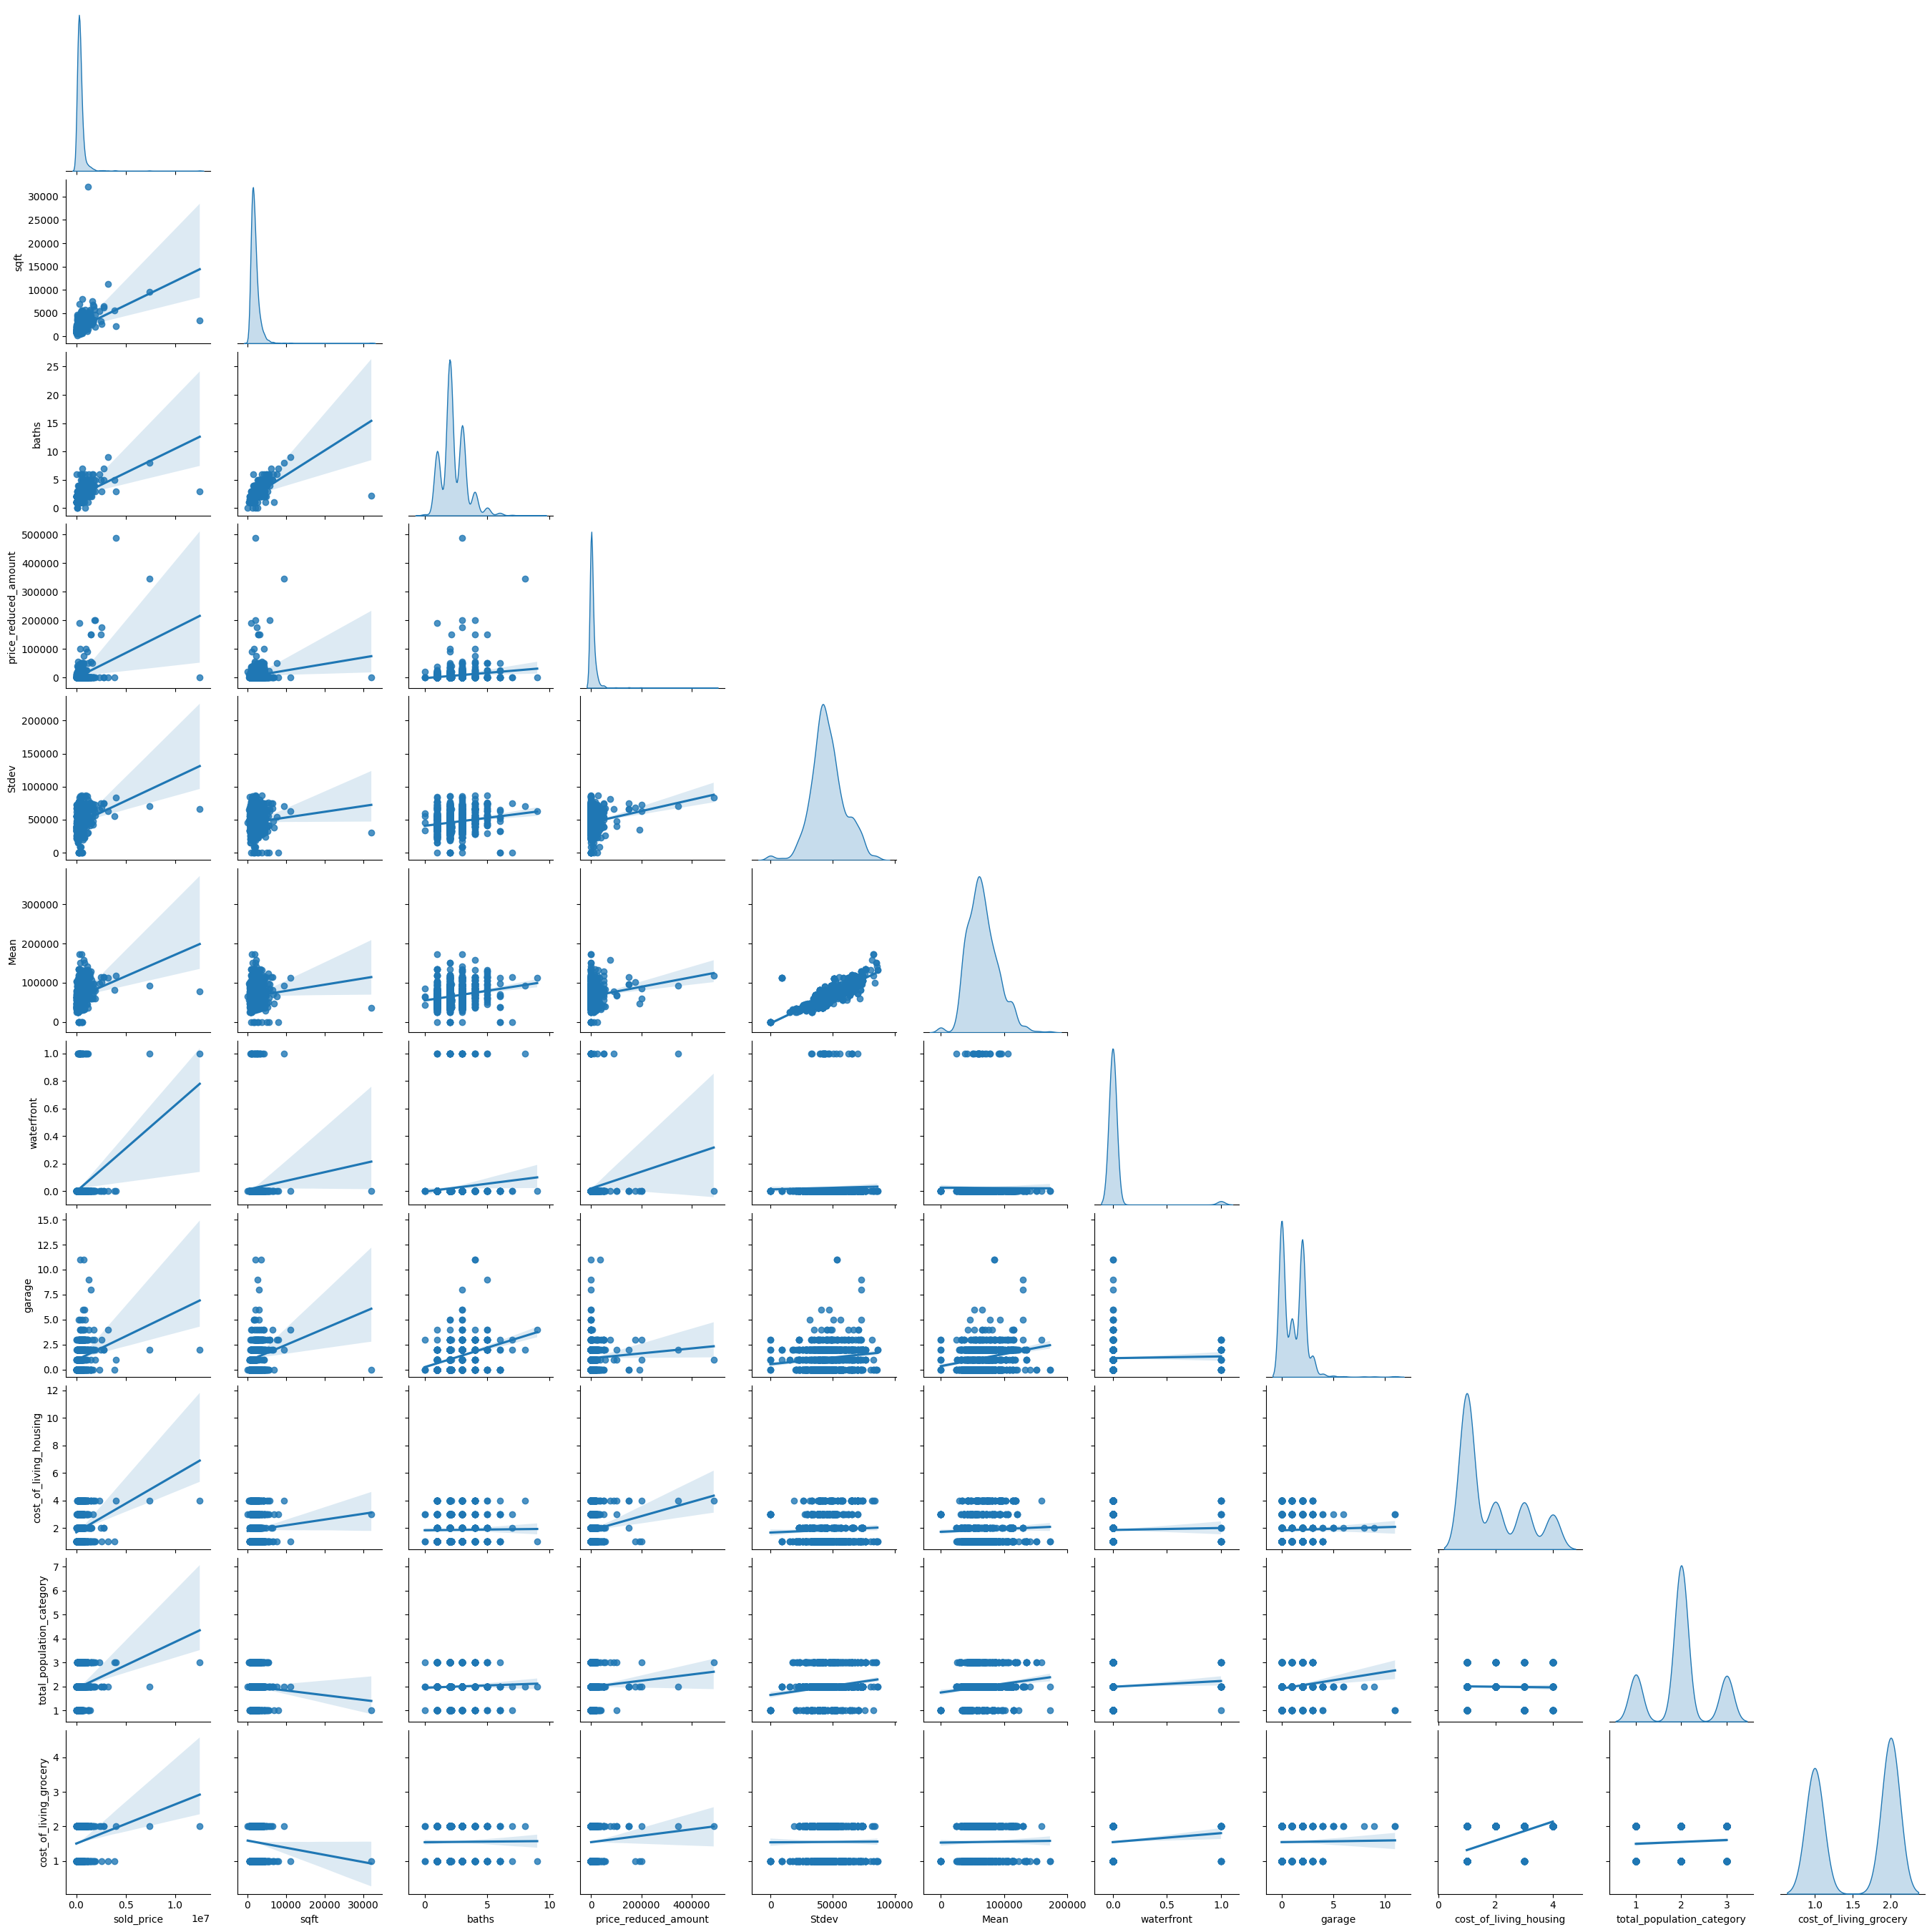

In [306]:
#Creating a pair plot for all correlated Values
df = chosen_features.copy()

plt.figure(figsize=(15, 12))
sns.pairplot(df,diag_kind='kde',corner = True, kind = 'reg')

plt.show()

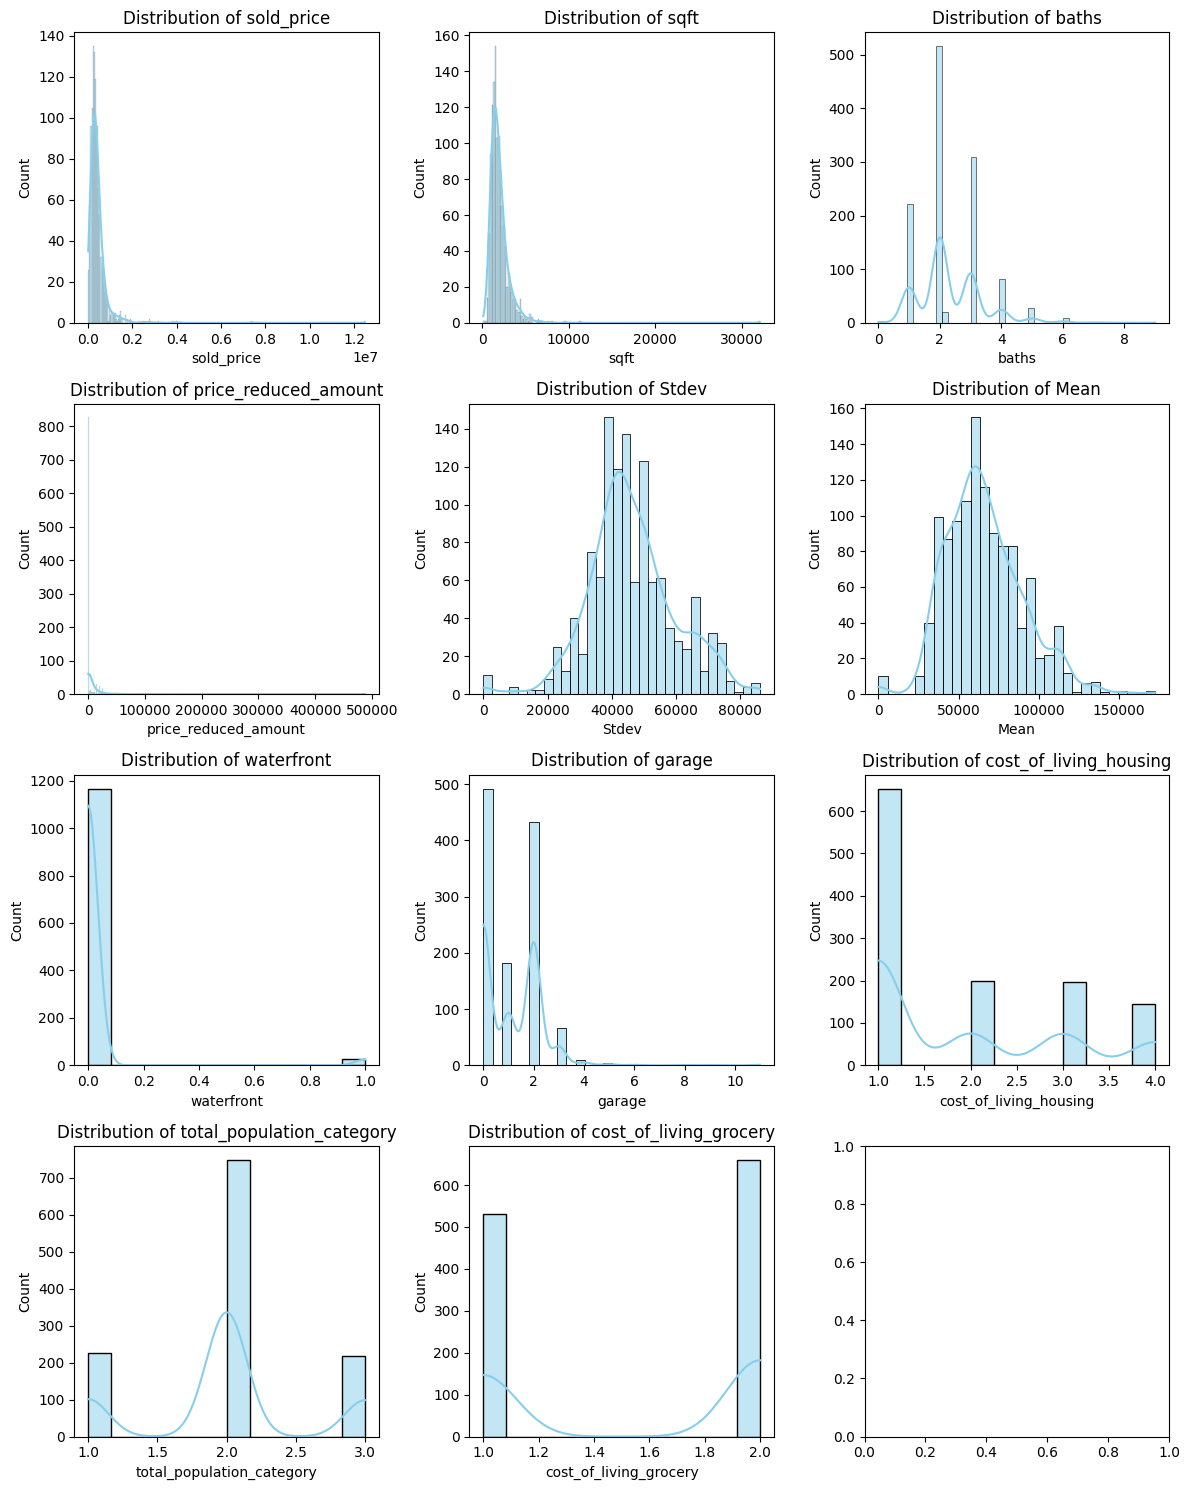

In [307]:
#Creating grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(12,15))

# Flatten the axes
axes = axes.flatten()

# Plot the distribution of each column
for i, column in enumerate(chosen_features.columns):
    sns.histplot(chosen_features[column], kde=True, ax=axes[i], color='skyblue') 
    axes[i].set_title(f'Distribution of {column}')


plt.tight_layout()
plt.show()

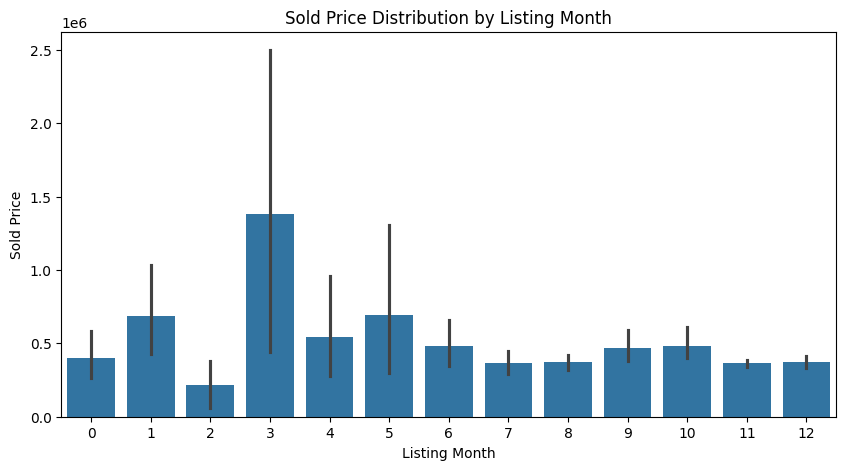

In [313]:
dataset = pd.read_csv('cleaned_income_merged_data.csv')
plt.figure(figsize=(10,5))
sns.barplot(x=dataset['list_month'], y=dataset['sold_price'])
plt.title("Sold Price Distribution by Listing Month")
plt.xlabel("Listing Month")
plt.ylabel("Sold Price")
plt.show()

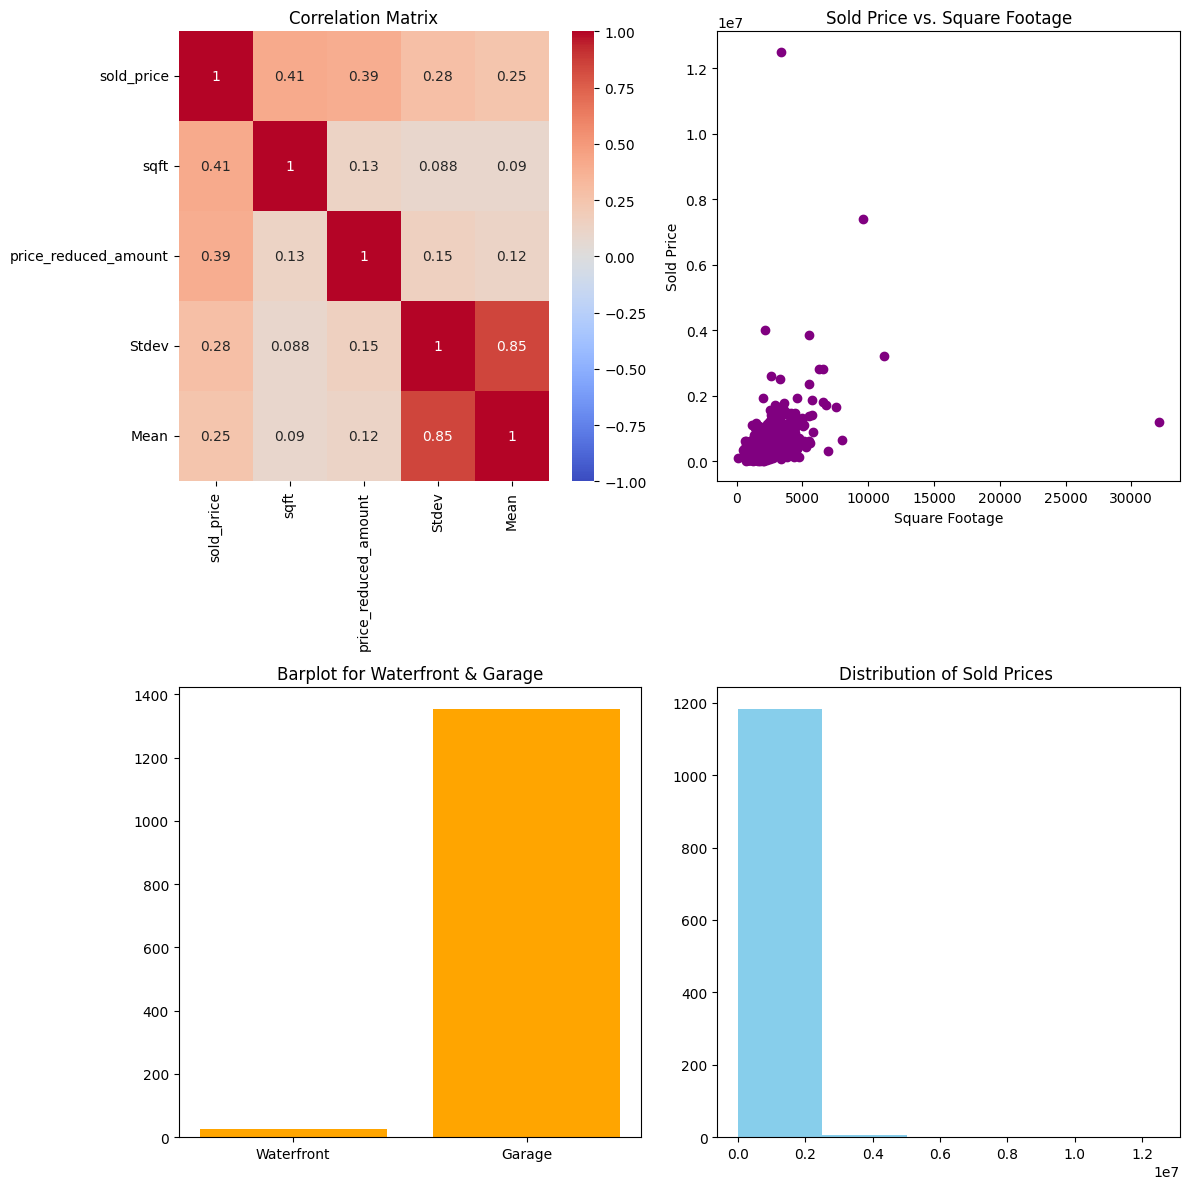

In [314]:
#Create figure and grid
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

#Creating tables and assigning locations in grid
corr = df[['sold_price', 'sqft', 'price_reduced_amount', 'Stdev', 'Mean']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[0, 0], vmin=-1, vmax=1)
axs[0, 0].set_title('Correlation Matrix')

axs[0, 1].scatter(df['sqft'], df['sold_price'], color='purple')
axs[0, 1].set_title('Sold Price vs. Square Footage')
axs[0, 1].set_xlabel('Square Footage')
axs[0, 1].set_ylabel('Sold Price')

axs[1, 0].bar(['Waterfront', 'Garage'], [df['waterfront'].sum(), df['garage'].sum()], color='orange')
axs[1, 0].set_title('Barplot for Waterfront & Garage')

axs[1, 1].hist(df['sold_price'], bins = 5, color = 'skyblue',)
axs[1, 1].set_title('Distribution of Sold Prices ')

#Showing plot
plt.tight_layout()
plt.show()


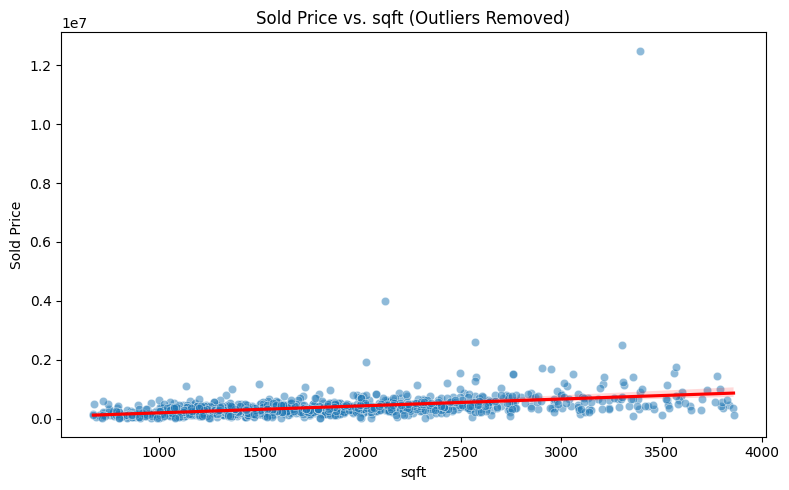

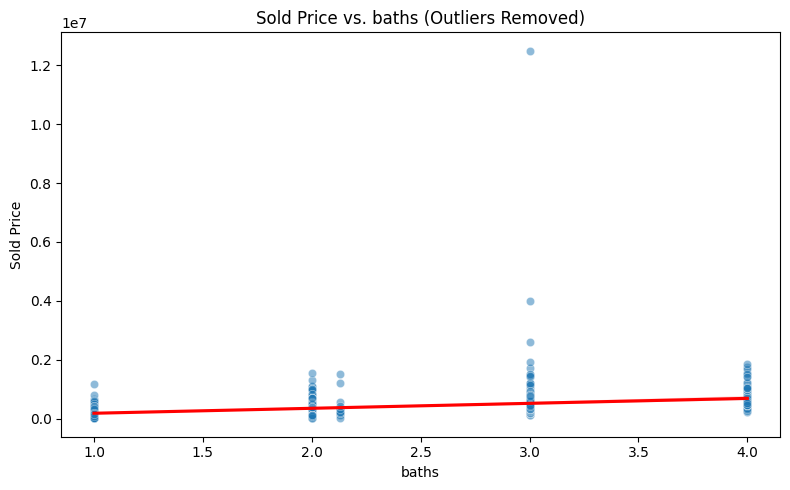

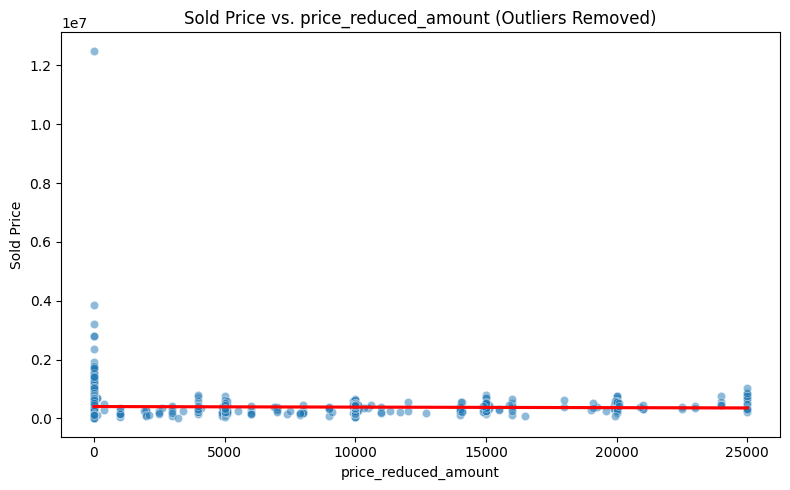

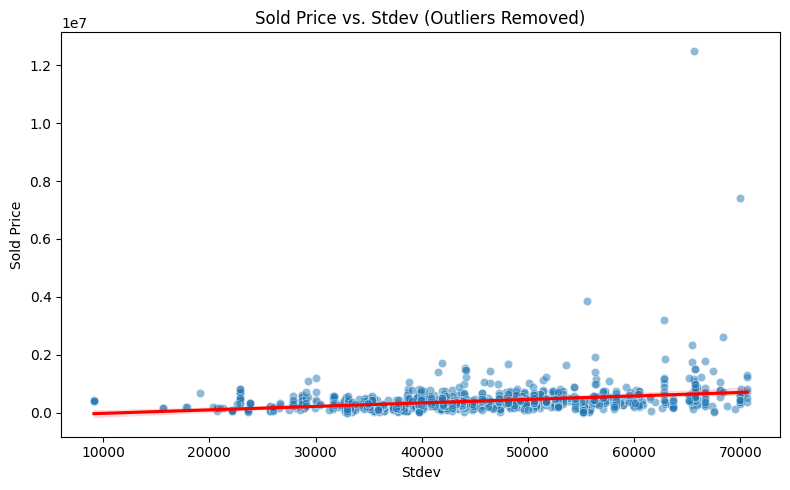

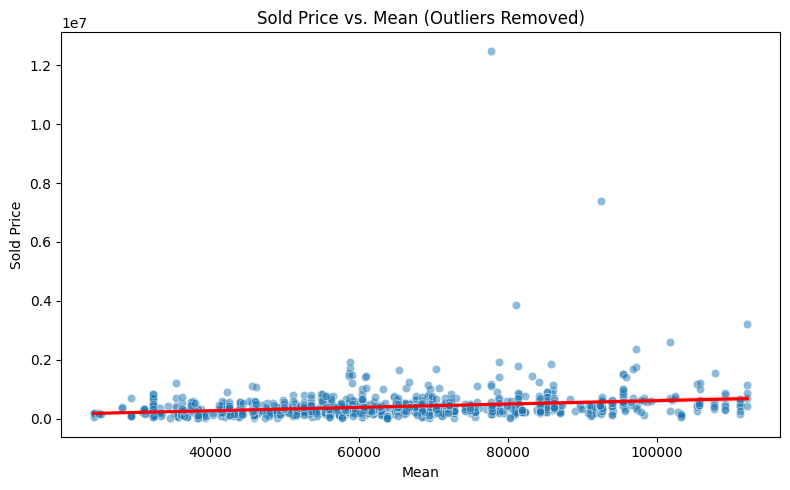

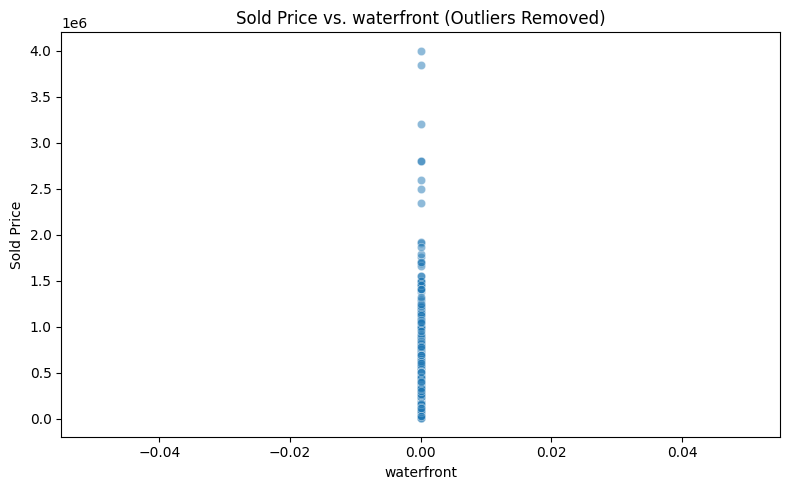

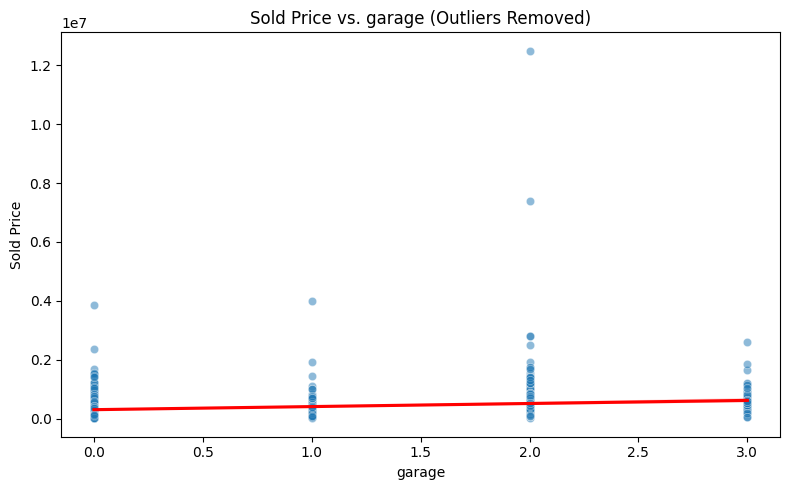

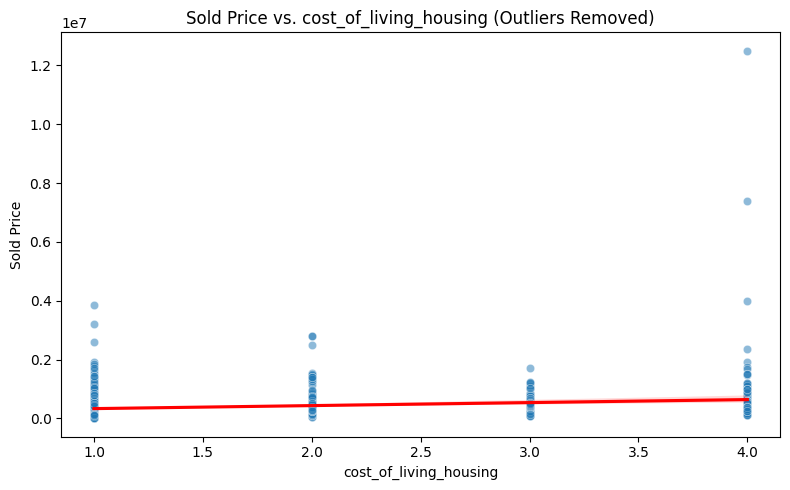

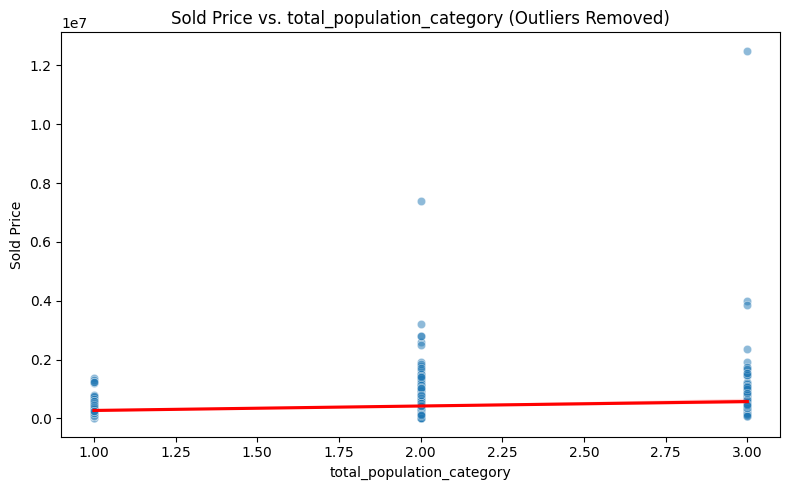

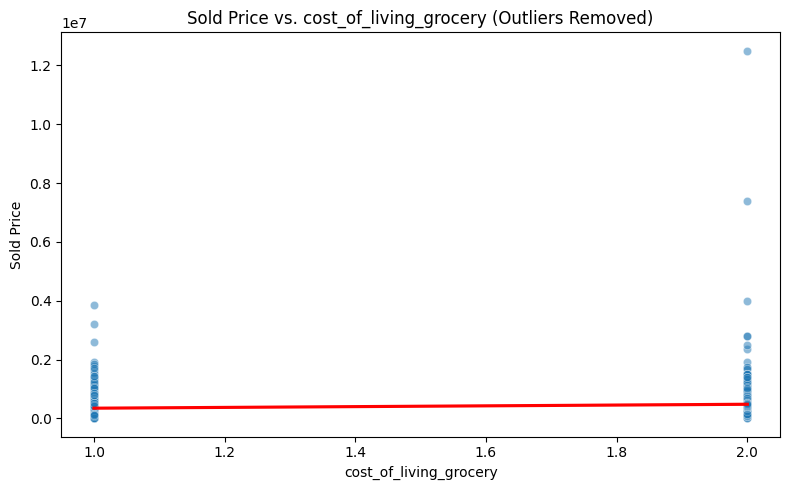

In [ ]:
#Loop through the columns to create quartiles 
for var in df.columns:
    if var == 'sold_price':
        continue
    q_low = df[var].quantile(0.01)
    q_high = df[var].quantile(0.95)
    df_filtered = df[(df[var] >= q_low) & (df[var] <= q_high)]
    
    # Create a new figure for each plot
    plt.figure(figsize=(8, 5))

    # Scatter plot and regression line
    sns.scatterplot(x=df_filtered[var], y=df_filtered['sold_price'], alpha=0.5)
    sns.regplot(x=df_filtered[var], y=df_filtered['sold_price'], scatter=False, color='red')

    # Set plot titles and labels
    plt.title(f"Sold Price vs. {var} (Outliers Removed)")
    plt.xlabel(var)
    plt.ylabel("Sold Price")

    # Show the plot
    plt.tight_layout()
    plt.show()


## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [ ]:
# Apply Log Transform to sold_price, sqft, price_reduced_amount to scale for outliers
chosen_features.loc[:, 'sold_price'] = np.log1p(chosen_features['sold_price'])
chosen_features.loc[:, 'sqft'] = np.log1p(chosen_features['sqft'])
chosen_features.loc[:, 'price_reduced_amount'] = np.log1p(chosen_features['price_reduced_amount'])

In [ ]:
# Confirm skew after running Log Transformation
chosen_features.skew()

sold_price                  -0.960424
sqft                         0.038762
baths                        1.186509
price_reduced_amount         0.825834
Stdev                        0.099015
Mean                         0.630638
waterfront                   6.555653
garage                       1.705574
cost_of_living_housing       0.850844
total_population_category    0.002603
cost_of_living_grocery      -0.216286
dtype: float64

In [ ]:
# Save chosen features to files
chosen_features.to_csv('processed/chosen_features.csv', index=False)